 ## Sustainability optimisation: sample solution



Load the networks and construct onion layer feature vectors.

In [25]:
import networkx as nx
import psutil, time, os, gc, statistics, warnings
import pandas as pd
import numpy as np
import glob
from memory_profiler import memory_usage
from codecarbon import EmissionsTracker
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

### Functions

#### memory usage

In [26]:
# Function to get memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / 1024 / 1024  # Memory in MB

#### different methods

In [27]:
def plot_validation_curve(estimator, X, y, param_name, param_range, cv=5, title="Validation Curve"):
    # Convert None in param_range to a large integer for plotting
    plot_param_range = [100 if x is None else x for x in param_range]
    
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range, cv=cv, scoring='accuracy', n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(plot_param_range, train_mean, label="Training score", color="#1f77b4")
    plt.plot(plot_param_range, test_mean, label="Cross-validation score", color="#ff7f0e")
    plt.fill_between(plot_param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color="#1f77b4")
    plt.fill_between(plot_param_range, test_mean - test_std, test_mean + test_std, alpha=0.1, color="#ff7f0e")
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Function to run analysis with multiple iterations
def run_analysis_with_repeats(data_dir, num_runs=1):
    results = []
    data_rows = None
    data_targets = None
    
    for _ in range(num_runs):
        gc.collect()  # Clear memory before each run
        result, rows, targets = analyze_ml_models(data_dir)
        results.append(result)
        data_rows = rows  # Store the last iteration's rows and targets
        data_targets = targets
    
    # Aggregate metrics dynamically
    aggregated_results = []
    for method in ['LR', 'RF', 'DT']:
        metrics = {
            "Method": method,
            "Accuracy": statistics.mean([r[f"{method} Accuracy"] for r in results]),
            "Train Time (s)": statistics.mean([r[f"{method} Train Time (s)"] for r in results]),
            "Pred Time (s)": statistics.mean([r[f"{method} Pred Time (s)"] for r in results]),
            "Memory (MB)": statistics.mean([r[f"{method} Memory (MB)"] for r in results]),
            "Emissions (kg CO2eq)": statistics.mean([r[f"{method} Emissions (kg CO2eq)"] for r in results])
        }
        aggregated_results.append(metrics)
    
    return aggregated_results, (pd.DataFrame(data_rows), pd.Series(data_targets))

# Function to analyze machine learning models dynamically
def analyze_ml_models(data_dir):
    rows = []
    targets = []
    
    labels = os.listdir(data_dir)
    for label in labels:
        for path in glob.glob(os.path.join(data_dir, label, "*")):
            try:
                G = nx.read_adjlist(path, nodetype=int)
                od = nx.onion_layers(G)
                layer_size = {i: 0 for i in range(1, 101)}  # Initialize all layers with 0
                for i in range(1, 101):
                    layer_i = [v for v in od.keys() if od[v] == i]
                    layer_size[i] = len(layer_i)
                
                rows.append(pd.Series(layer_size, name=path))
                targets.append(label)
            except (nx.NetworkXError, IOError) as e:
                print(f"Error reading file {path}: {e}")
                continue
    
    # Convert to DataFrame and handle missing values
    X_df = pd.DataFrame(rows).fillna(0)  # Fill NaN with 0
    if not np.all(np.isfinite(X_df)):
        print("Warning: Non-finite values found in X_df. Replacing with 0.")
        X_df = X_df.replace([np.inf, -np.inf], 0)
    
    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X_df)
    y = pd.Series(targets)
    
    # Verify scaled data
    if not np.all(np.isfinite(X)):
        print("Warning: Non-finite values found in scaled X. Replacing with 0.")
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=33)
    
    # Define models and their parameter grids
    models = [
        {
            'name': 'LR',
            'estimator': LogisticRegression(class_weight='balanced'),
            'param_grid': {'C': [0.01, 0.1, 1, 10, 100]}
        },
        {
            'name': 'RF',
            'estimator': RandomForestClassifier(class_weight='balanced', random_state=33),
            'param_grid': {
                'n_estimators': [50, 100],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5]
            }
        },
        {
            'name': 'DT',
            'estimator': DecisionTreeClassifier(class_weight='balanced', random_state=33),
            'param_grid': {
                'max_depth': [None, 5, 10, 15, 20],
                'min_samples_split': [2, 5, 10]
            }
        }
    ]
    
    results = {}
    
    # Process each model dynamically
    for model in models:
        name = model['name']
        estimator = GridSearchCV(model['estimator'], model['param_grid'], cv=5, scoring='accuracy', n_jobs=-1)
        
        # Train model
        tracker = EmissionsTracker(project_name=name)
        tracker.start()
        start_time = time.time()
        mem_usage = memory_usage((estimator.fit, (X_train, y_train)), interval=0.1, max_usage=True)
        train_time = time.time() - start_time
        
        # Predict
        pred_start = time.time()
        predictions = estimator.predict(X_test)
        pred_time = time.time() - pred_start
        emissions = tracker.stop()
        
        # Store metrics
        results[f"{name} Accuracy"] = accuracy_score(y_test, predictions)
        results[f"{name} Train Time (s)"] = train_time
        results[f"{name} Pred Time (s)"] = pred_time
        results[f"{name} Memory (MB)"] = mem_usage
        results[f"{name} Emissions (kg CO2eq)"] = emissions
        
        # Print evaluation
        print(f"\n{name} Evaluation (Best params={estimator.best_params_}):")
        print(f"Accuracy: {accuracy_score(y_test, predictions):.4f}")
        print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, predictions, labels=y.unique())}")
        print(f"\nClassification Report:\n{classification_report(y_test, predictions, target_names=y.unique())}")
    
    # Print competition metrics
    print(f"\nCompetition Metrics:")
    for model in models:
        name = model['name']
        print(f"{name}: Train Time={results[f'{name} Train Time (s)']:.4f}s, "
              f"Pred Time={results[f'{name} Pred Time (s)']:.4f}s, "
              f"Memory={results[f'{name} Memory (MB)']:.2f}MB, "
              f"Emissions={results[f'{name} Emissions (kg CO2eq)']:.6f}kg CO2eq")
    
    return results, rows, targets

### main run

[codecarbon WARNING @ 20:07:18] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 20:07:18] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 20:07:18] [setup] RAM Tracking...
[codecarbon INFO @ 20:07:18] [setup] CPU Tracking...
[codecarbon WARNING @ 20:07:19] We saw that you have a Apple M4 but we don't know it. Please contact us.
[codecarbon WARNING @ 20:07:19] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS detected: Please install Intel Power Gadget or enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 20:07:19] CPU Model on constant consumption mode: Apple M4
[codecarbon WARNING @ 20:07:19] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 20:07:19] [setup] GPU Tracking...
[codecarbon INFO @ 20:07:19] No GPU found.
[codecarbon INFO @ 20:07:19] The below tracking methods have been set up:



LR Evaluation (Best params={'C': 0.01}):
Accuracy: 0.5000

Confusion Matrix:
[[ 7  0]
 [10  3]]

Classification Report:
              precision    recall  f1-score   support

       GEOM4       1.00      0.23      0.38        13
         ER4       0.41      1.00      0.58         7

    accuracy                           0.50        20
   macro avg       0.71      0.62      0.48        20
weighted avg       0.79      0.50      0.45        20



[codecarbon WARNING @ 20:07:39] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS detected: Please install Intel Power Gadget or enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 20:07:39] CPU Model on constant consumption mode: Apple M4
[codecarbon WARNING @ 20:07:39] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 20:07:39] [setup] GPU Tracking...
[codecarbon INFO @ 20:07:39] No GPU found.
[codecarbon INFO @ 20:07:39] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 20:07:39] >>> Tracker's metadata:
[codecarbon INFO @ 20:07:39]   Platform system: macOS-15.5-arm64-arm-64bit-Mach-O
[codecarbon INFO @ 20:07:39]   Python version: 3.13.5
[codecarbon INFO @ 20:07:39]   CodeCarbon version: 3.0.2
[codecarbon INFO @ 20:07:3


RF Evaluation (Best params={'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}):
Accuracy: 0.9000

Confusion Matrix:
[[ 7  0]
 [ 2 11]]

Classification Report:
              precision    recall  f1-score   support

       GEOM4       1.00      0.85      0.92        13
         ER4       0.78      1.00      0.88         7

    accuracy                           0.90        20
   macro avg       0.89      0.92      0.90        20
weighted avg       0.92      0.90      0.90        20



[codecarbon WARNING @ 20:07:42] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS detected: Please install Intel Power Gadget or enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 20:07:42] CPU Model on constant consumption mode: Apple M4
[codecarbon WARNING @ 20:07:42] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 20:07:42] [setup] GPU Tracking...
[codecarbon INFO @ 20:07:42] No GPU found.
[codecarbon INFO @ 20:07:42] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 20:07:42] >>> Tracker's metadata:
[codecarbon INFO @ 20:07:42]   Platform system: macOS-15.5-arm64-arm-64bit-Mach-O
[codecarbon INFO @ 20:07:42]   Python version: 3.13.5
[codecarbon INFO @ 20:07:42]   CodeCarbon version: 3.0.2
[codecarbon INFO @ 20:07:4


DT Evaluation (Best params={'max_depth': None, 'min_samples_split': 2}):
Accuracy: 0.8500

Confusion Matrix:
[[ 7  0]
 [ 3 10]]

Classification Report:
              precision    recall  f1-score   support

       GEOM4       1.00      0.77      0.87        13
         ER4       0.70      1.00      0.82         7

    accuracy                           0.85        20
   macro avg       0.85      0.88      0.85        20
weighted avg       0.89      0.85      0.85        20


Competition Metrics:
LR: Train Time=17.5826s, Pred Time=0.0003s, Memory=1236.06MB, Emissions=0.000053kg CO2eq
RF: Train Time=1.6129s, Pred Time=0.0007s, Memory=476.64MB, Emissions=0.000005kg CO2eq
DT: Train Time=0.8984s, Pred Time=0.0002s, Memory=217.80MB, Emissions=0.000003kg CO2eq

Table: Machine Learning Performance Comparison
  Method  Accuracy  Train Time (s)  Pred Time (s)  Memory (MB)  \
0     LR      0.50       17.582581       0.000268  1236.062500   
1     RF      0.90        1.612940       0.000675   476

/opt/homebrew/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:165: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/homebrew/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:165: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/homebrew/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:165: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/homebrew/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:295: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/opt/homebrew/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:295: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/opt/homebrew/lib/python3.13/site-packages/sklearn/l

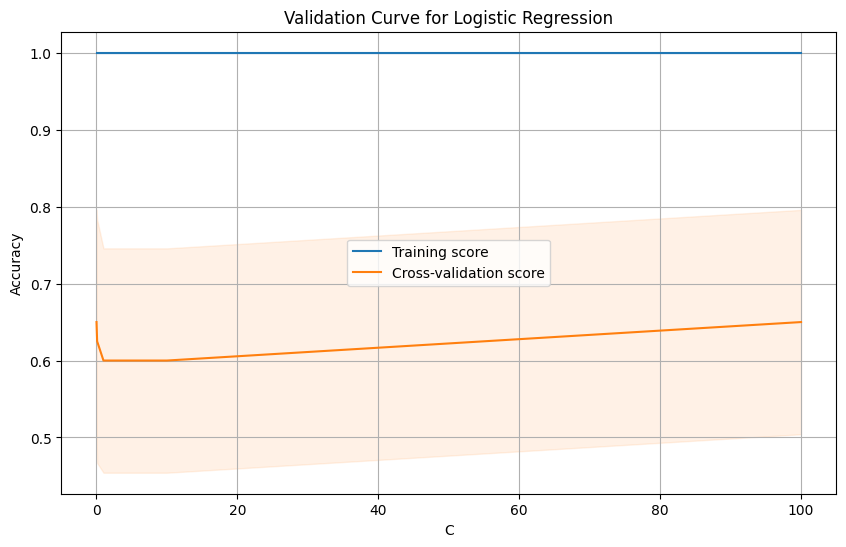

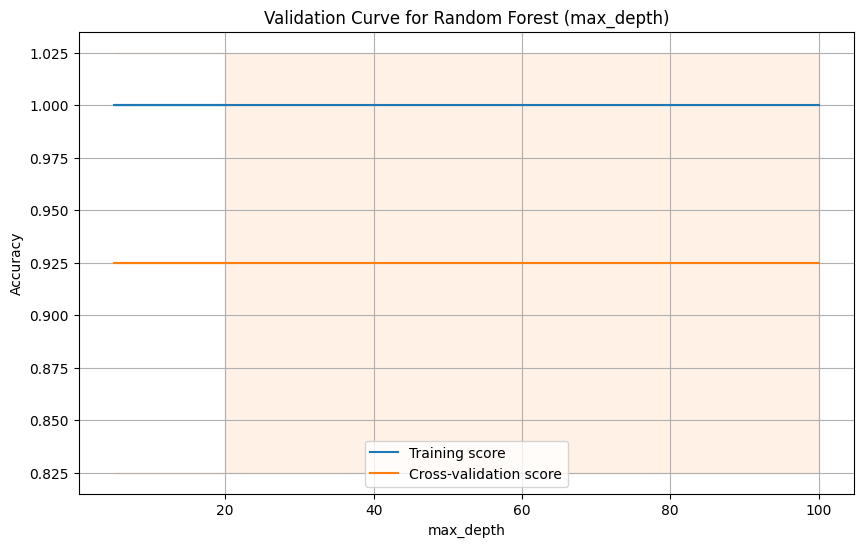

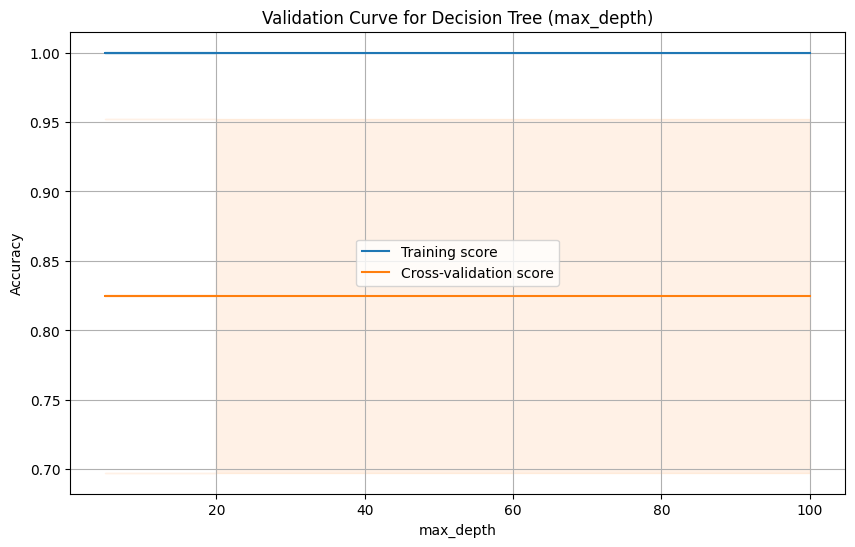

In [28]:
def main():
    data_dir = "data"
    
    if not os.path.exists(data_dir):
        print(f"Error: {data_dir} directory not found.")
        return
    
    num_runs = 1  # Set to 1 for single run as in original code
    ml_metrics, (X, y) = run_analysis_with_repeats(data_dir, num_runs)
    
    print("\nTable: Machine Learning Performance Comparison")
    ml_df = pd.DataFrame(ml_metrics)
    print(ml_df.round(6))
    ml_df.to_csv("ml_analysis_comparison.csv", index=False)
    print("\nMachine learning results saved to ml_analysis_comparison.csv")
    
    # Validation curves
    lr = LogisticRegression(class_weight='balanced')
    plot_validation_curve(lr, X, y, param_name='C', param_range=[0.01, 0.1, 1, 10, 100], title="Validation Curve for Logistic Regression")
    
    rf = RandomForestClassifier(class_weight='balanced', random_state=33)
    plot_validation_curve(rf, X, y, param_name='max_depth', param_range=[None, 5, 10, 15, 20], title="Validation Curve for Random Forest (max_depth)")
    
    dt = DecisionTreeClassifier(class_weight='balanced', random_state=33)
    plot_validation_curve(dt, X, y, param_name='max_depth', param_range=[None, 5, 10, 15, 20], title="Validation Curve for Decision Tree (max_depth)")
    
    

if __name__ == "__main__":
    main()